# Extreme Heat Events in New York City: A 40-Year Analysis (1984-2023)

###  Haoqi Zhang (AryaAvery)

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

#### The data are donwloaded from [ERA5 hourly data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download) of Climate Data Storage.

In [3]:
daily_max_temp_path = '/home/jovyan/rces-assignments/Project/final/daily_max.nc'
daily_max_temp = xr.open_dataset(daily_max_temp_path) - 273.15

# 1. Long-Term Temperature Trends

### Some conceptural words in this research are defined as follow: 
#### -High temprature: Daily Maximum Temprature ≥ 32.0℃ (89.6℉)
#### -Extreme High temprature: Daily Maximum Temprature ≥ 35.0℃ (95℉)
#### -Heat Wave Events: ≥ 2 days with temperature ≥ 32.0℃ (89.6℉)  for 1 June through 31 August

## 1.1 High Temprature Trend

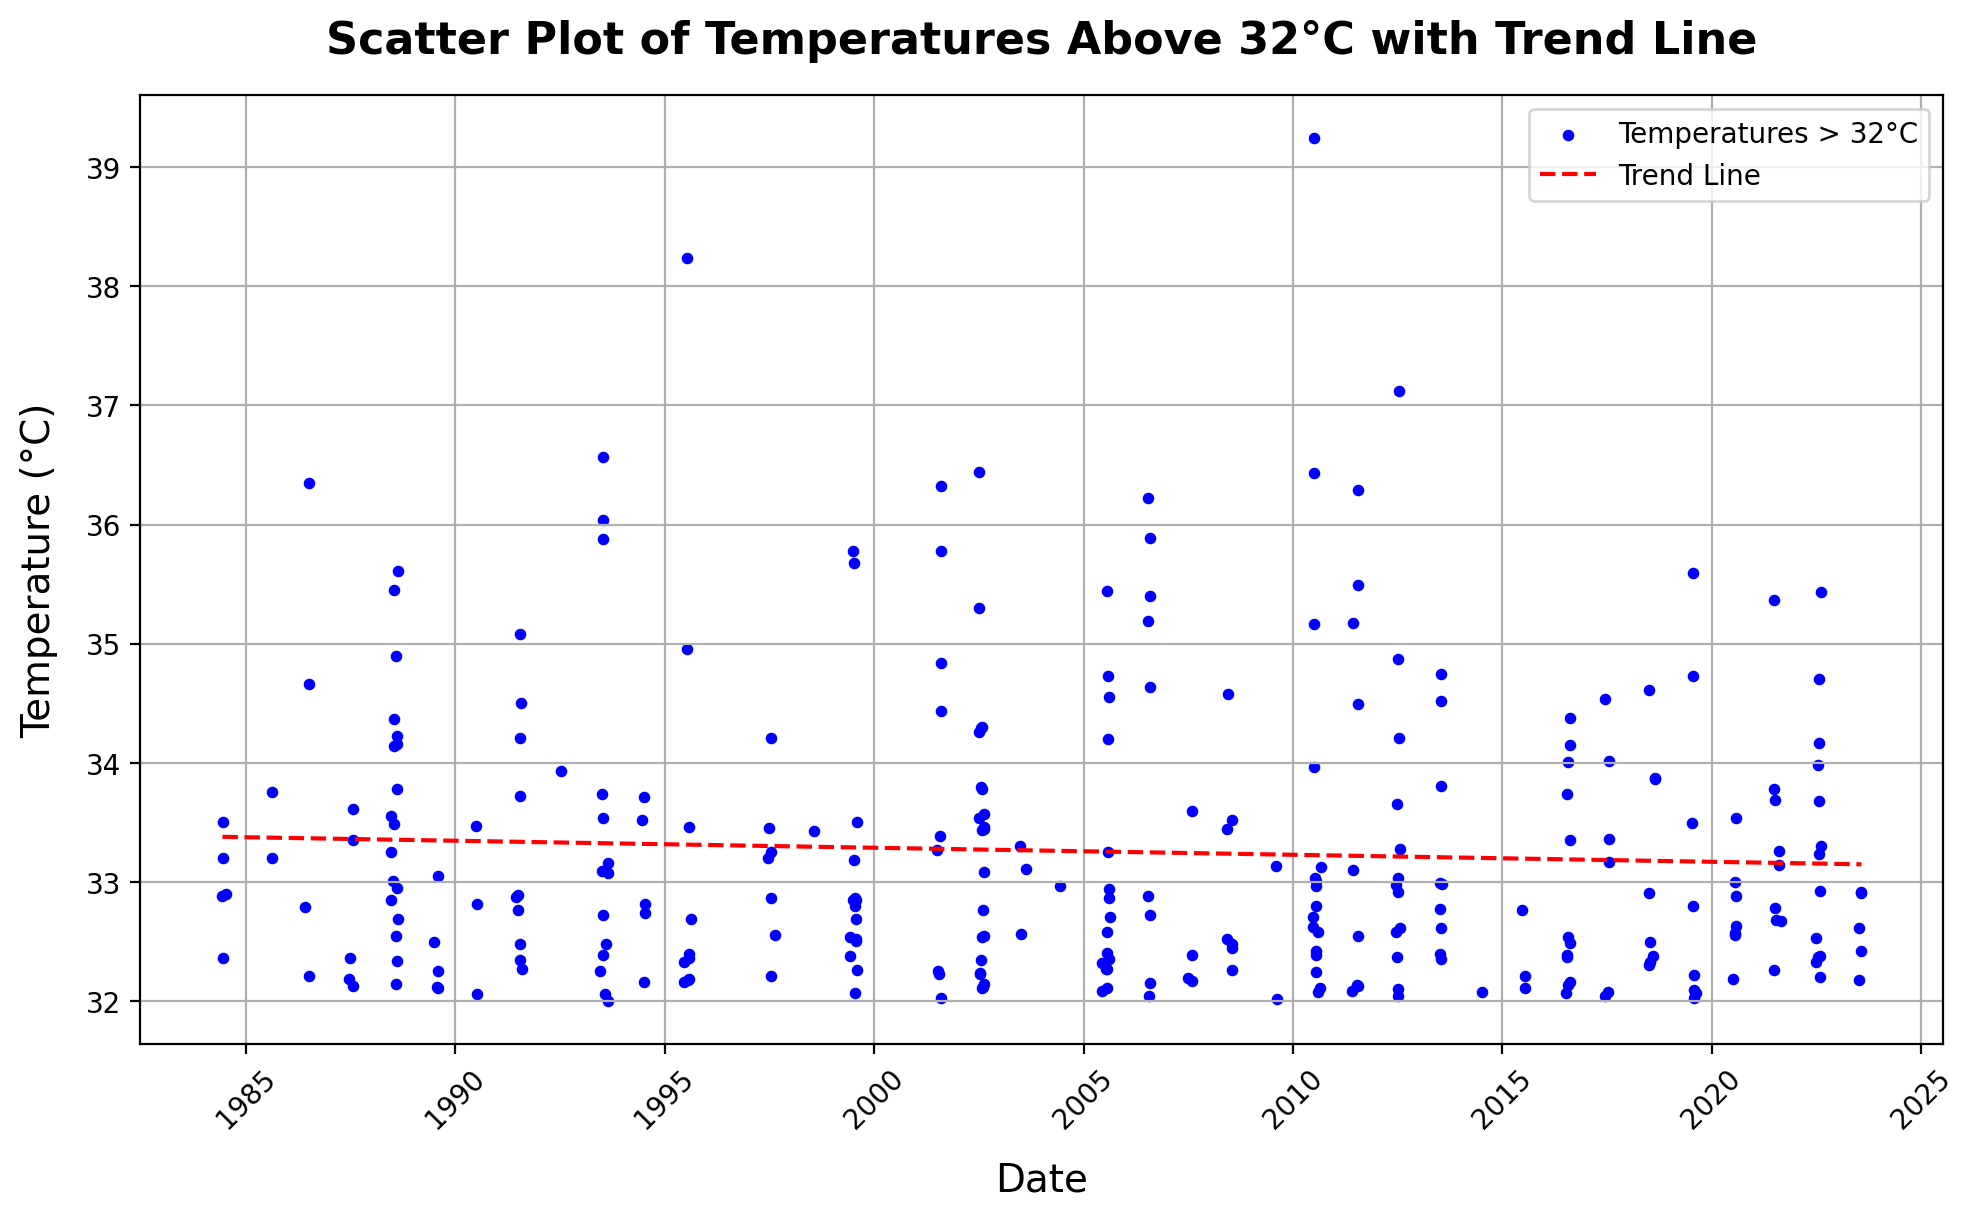

In [52]:
threshold = 32
high_temp_data = daily_max_temp['t2m'][daily_max_temp['t2m'] >= threshold]

dates = high_temp_data['time'].values
temperatures = high_temp_data.values

base_date = np.datetime64('1970-01-01')
dates_num = (dates - base_date).astype('timedelta64[D]').astype(int)  

model = LinearRegression()
model.fit(dates_num.reshape(-1, 1), temperatures)

trend_line = model.predict(dates_num.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(dates, temperatures, color='blue', s=10, label='Temperatures > 32°C')

plt.plot(dates, trend_line, color='red', linestyle='--', label='Trend Line')

plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Temperature (°C)', fontsize=14, labelpad=10)
plt.title('Scatter Plot of Temperatures Above 32°C with Trend Line', fontsize=16, fontweight="bold", pad=15)
plt.grid(True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()

## 1.2 Annual High-Temperature Days and Heatwave Events

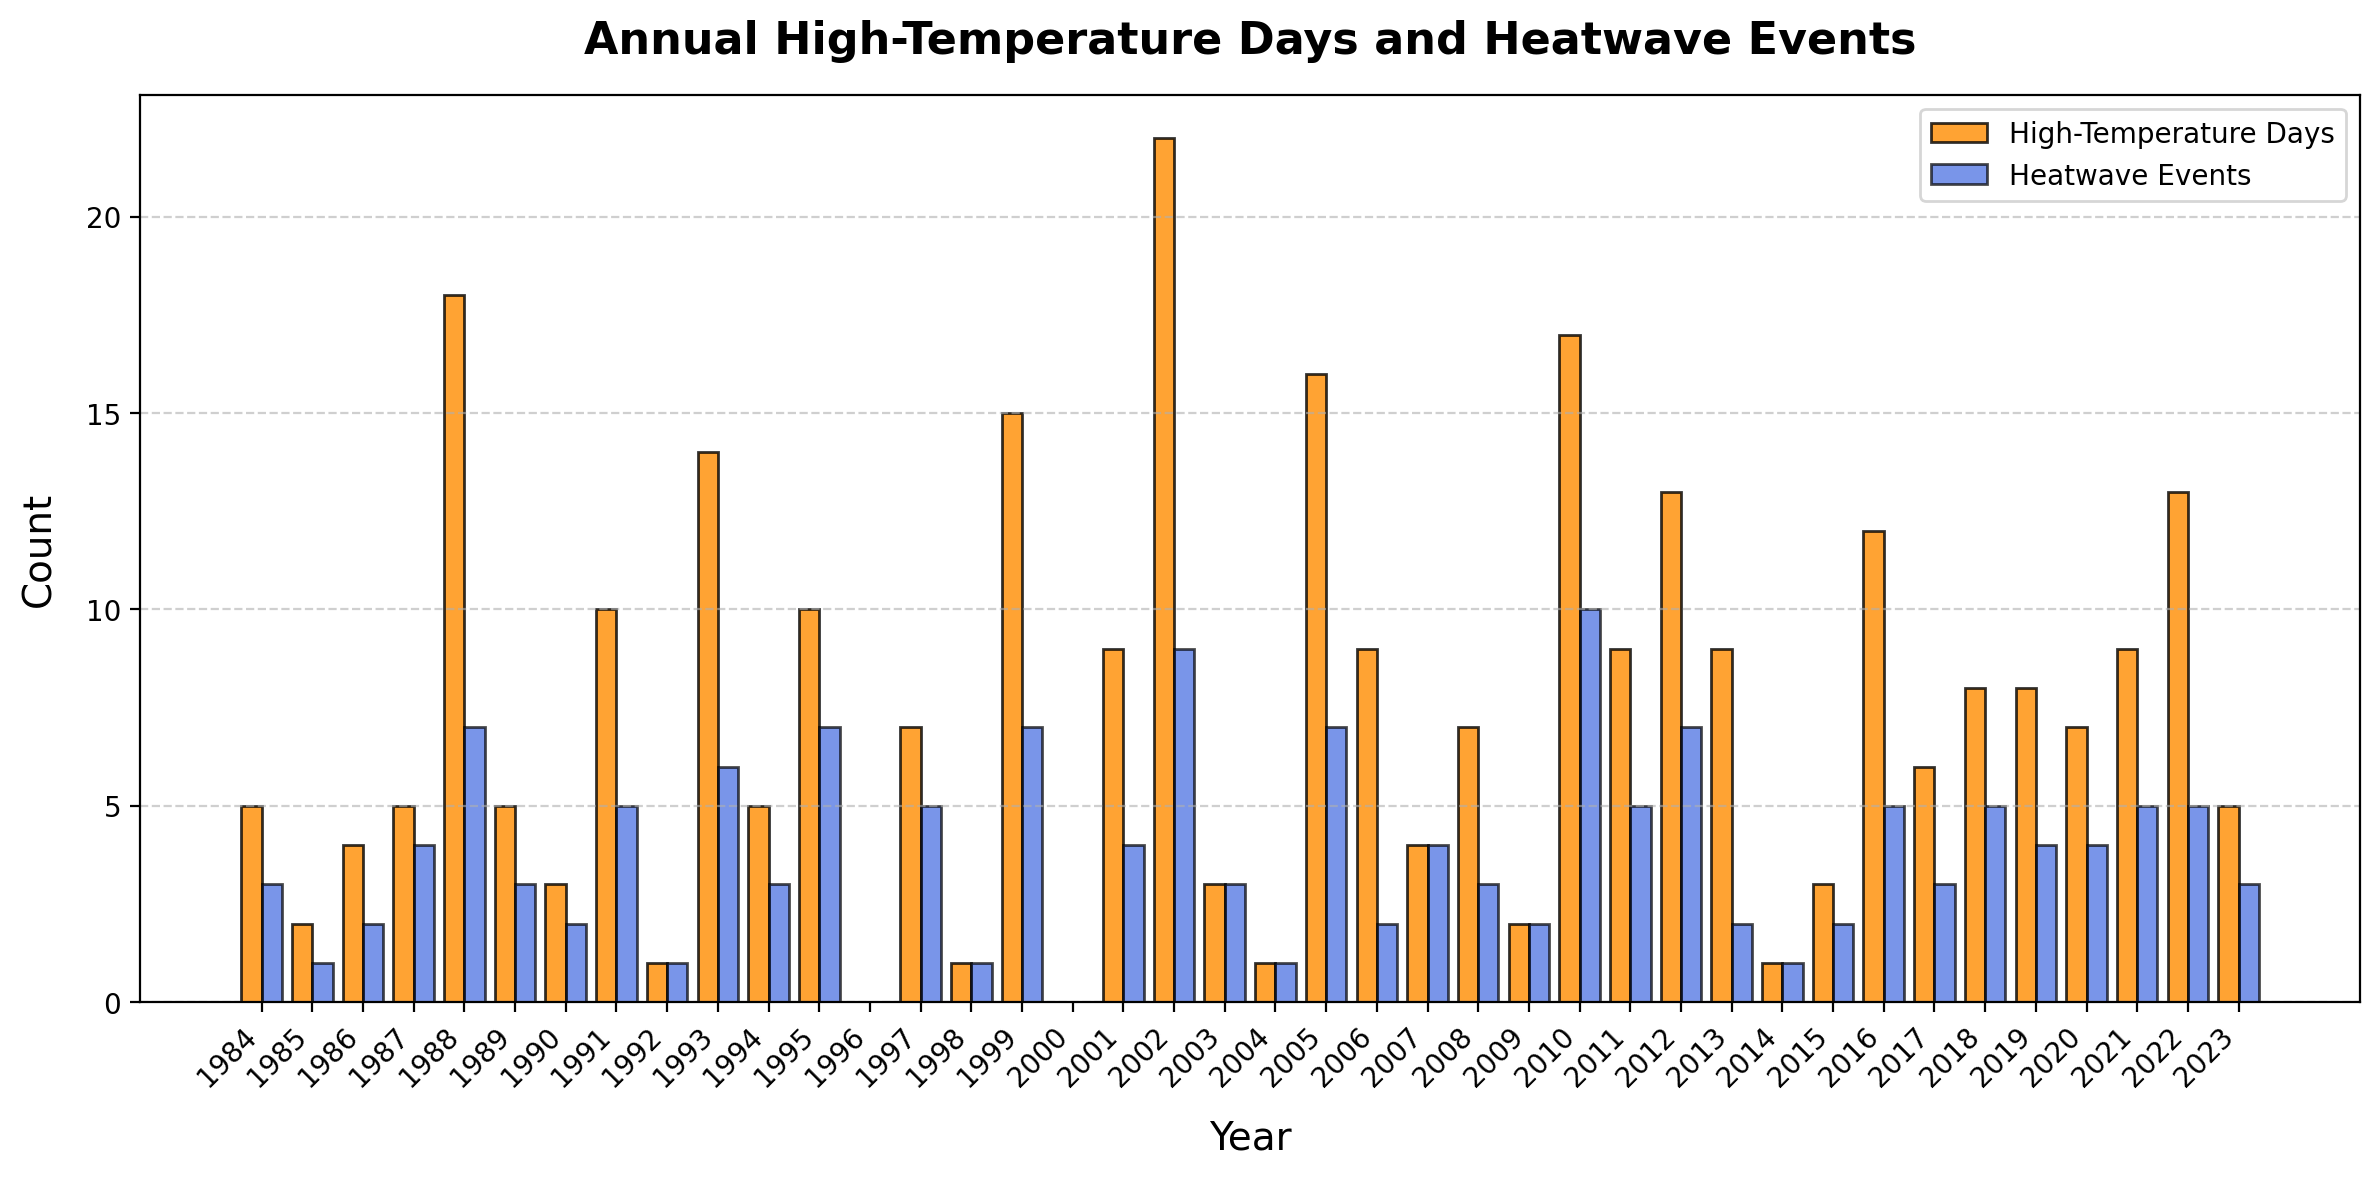

In [51]:
thresholds_per_year = 32
high_temp_days = (daily_max_temp['t2m'] >= thresholds_per_year).astype(int)

rolling_sum = high_temp_days.rolling(time=2).sum()  
heatwave_events = (rolling_sum >= 2).astype(int)    

heatwave_events = np.zeros_like(high_temp_days.values)

current_event = 0  
for i in range(len(high_temp_days)):
    if high_temp_days.values[i] == 1: 
        if i == 0 or high_temp_days.values[i - 1] == 0:  
            current_event += 1  
        heatwave_events[i] = current_event  
    else:
        heatwave_events[i] = 0  
        
heatwave_events_xr = xr.DataArray(
    heatwave_events,
    coords={'time': daily_max_temp['time'], 
            'year': daily_max_temp['time.year']},  
    dims=['time'],  
    name='heatwave_events'
)


def count_unique_events(x):
    return xr.DataArray(
        len(np.unique(x.values[x.values > 0])),
        coords={'year': [int(x['year'].values[0])]},  
        dims=['year'] 
    )


unique_heatwaves_per_year = heatwave_events_xr.groupby("year").apply(count_unique_events)


heatwave_counts = unique_heatwaves_per_year.values
years = unique_heatwaves_per_year.coords["year"].values

high_temp_days_per_year = high_temp_days.groupby("time.year").sum()
high_temp_days_counts = high_temp_days_per_year.values 

bar_width = 0.4

plt.figure(figsize=(12, 6))

index = np.arange(len(years))

plt.bar(index - bar_width/2, high_temp_days_counts, bar_width, 
        color="darkorange", edgecolor="black", alpha=0.8, 
        label="High-Temperature Days")

plt.bar(index + bar_width/2, heatwave_counts, bar_width, 
        color="royalblue", edgecolor="black", alpha=0.7, 
        label="Heatwave Events")

plt.xticks(index, years, rotation=45, ha='right')

plt.xlabel("Year",fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)
plt.title("Annual High-Temperature Days and Heatwave Events", fontsize=16, fontweight="bold", pad=15)

plt.legend()

plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()

## 1.3 Annual Days Above 21.1°C Dewpoint Temprature (with Trendline)

In [7]:
dewpoint_max_temp_path = '/home/jovyan/rces-assignments/Project/final/dewpoint_max_temp.nc'
dewpoint_max_temp = xr.open_dataset(dewpoint_max_temp_path) - 273.15
print(f"\n dewpoint_temp:\n{dewpoint_max_temp}")


 dewpoint_temp:
<xarray.Dataset> Size: 176kB
Dimensions:    (time: 14702)
Coordinates:
    number     int64 8B ...
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
    latitude   float64 8B ...
    longitude  float64 8B ...
  * time       (time) datetime64[ns] 118kB 1984-06-01 1984-06-02 ... 2024-08-31
Data variables:
    d2m        (time) float32 59kB 8.046 9.961 11.08 11.85 ... 19.25 16.29 18.63
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-29T20:57 GRIB to CDM+CF via cfgrib-0.9.1...


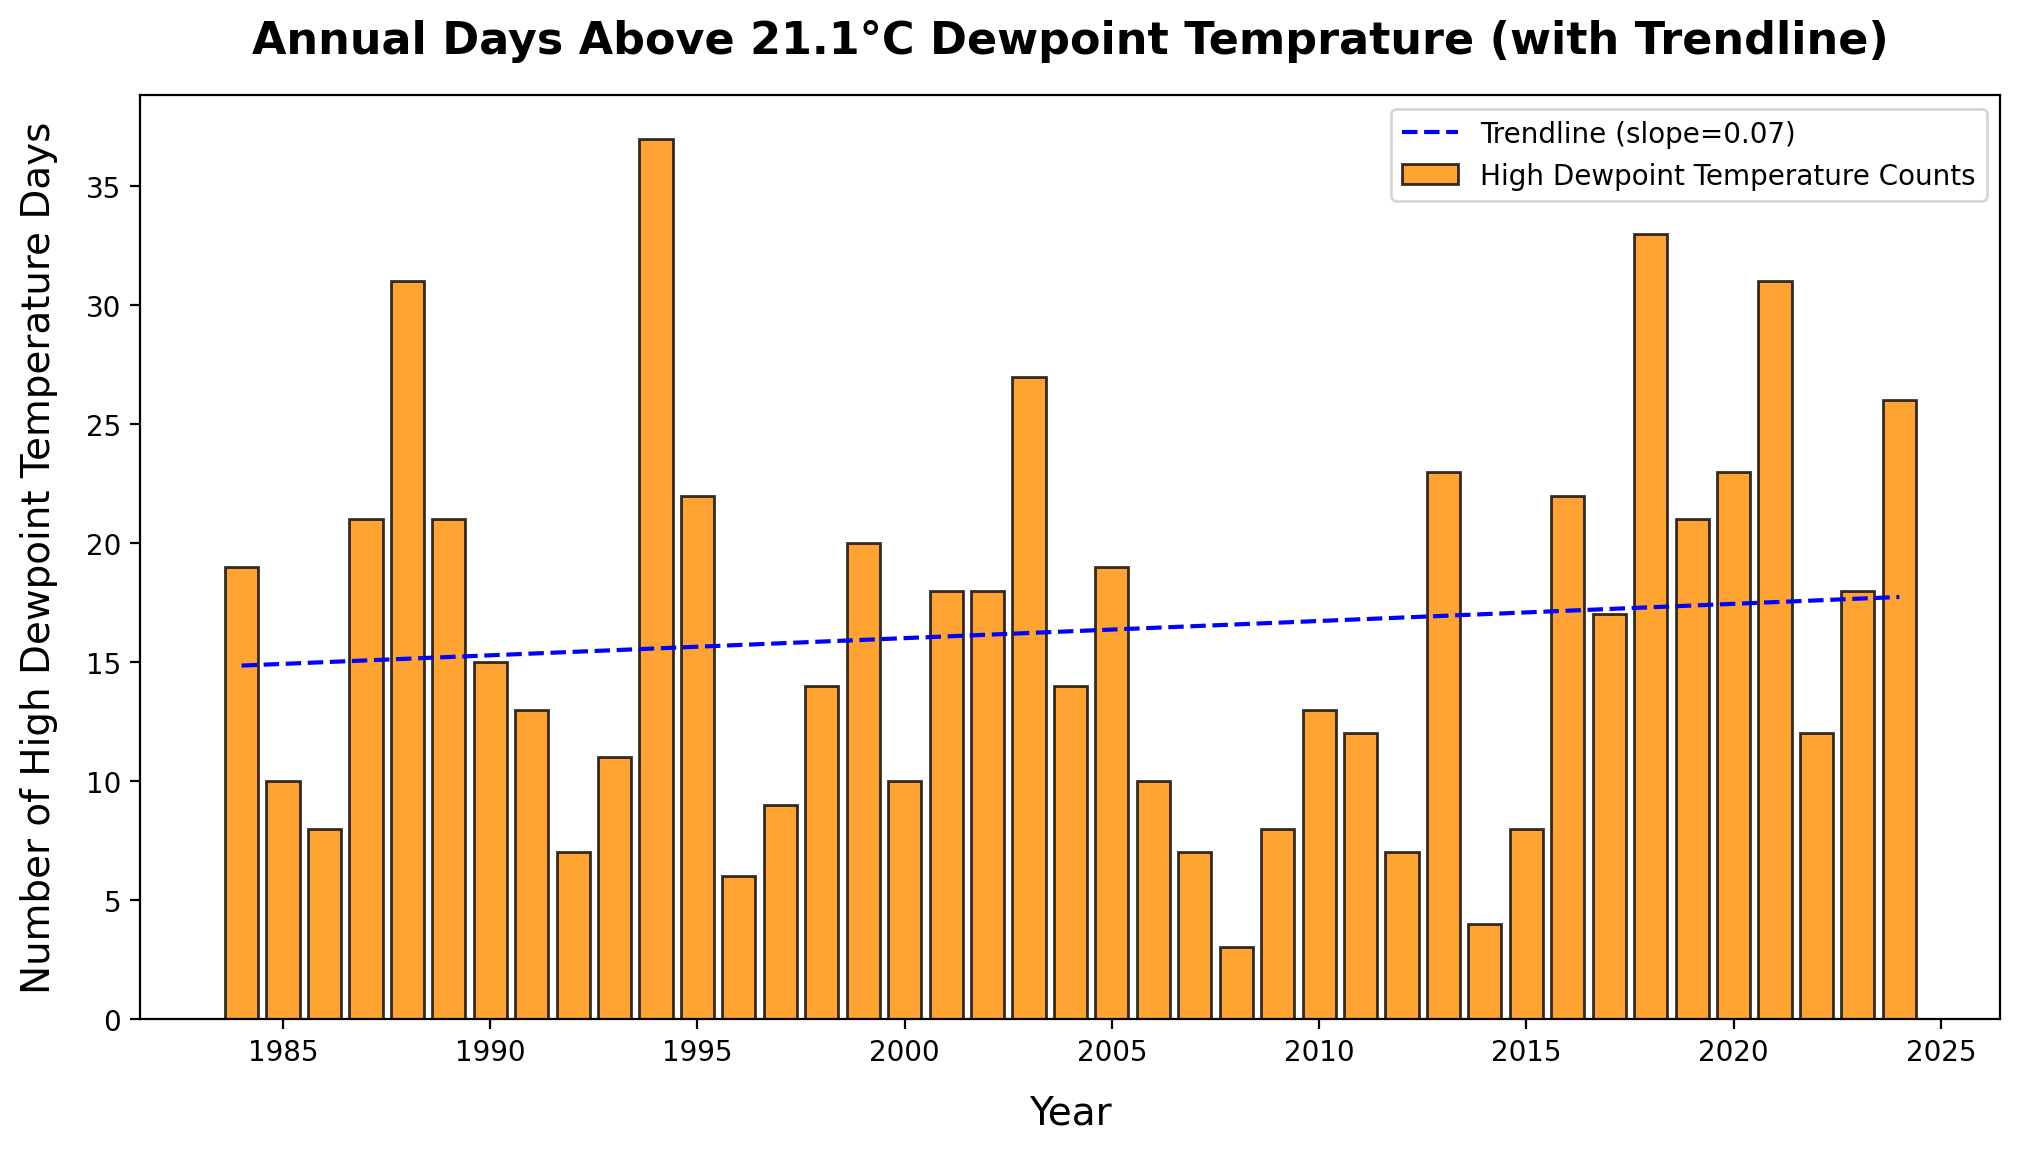

In [49]:
dewpoint_threshold = 21.1
high_dew_days = dewpoint_max_temp['d2m'] > dewpoint_threshold
   
high_dew_counts = high_dew_days.groupby('time.year').sum().values

years24 = dewpoint_max_temp['d2m'].groupby(dewpoint_max_temp['time.year']).max(dim='time')
years24 = years24 ['year'].values

slope_high, intercept_high, r_value, p_value, std_err = linregress(years24, high_dew_counts)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(years24, high_dew_counts, color="darkorange", edgecolor="black", alpha=0.8, label="High Dewpoint Temperature Counts")
ax.plot(years24, slope_high * years24 + intercept_high, color="blue", linestyle="--", label=f"Trendline (slope={slope_high:.2f})")
ax.set_xlabel("Year",  fontsize=14, labelpad=10)
ax.set_ylabel("Number of High Dewpoint Temperature Days",  fontsize=14, labelpad=10)
ax.set_title(f"Annual Days Above {dewpoint_threshold}°C Dewpoint Temprature (with Trendline)", fontsize=16, fontweight="bold", pad=15)

# Display the legend
ax.legend()

# 2. Seasonal Heat Characteristics

## 2.1 High Temperature Days in Summer Months

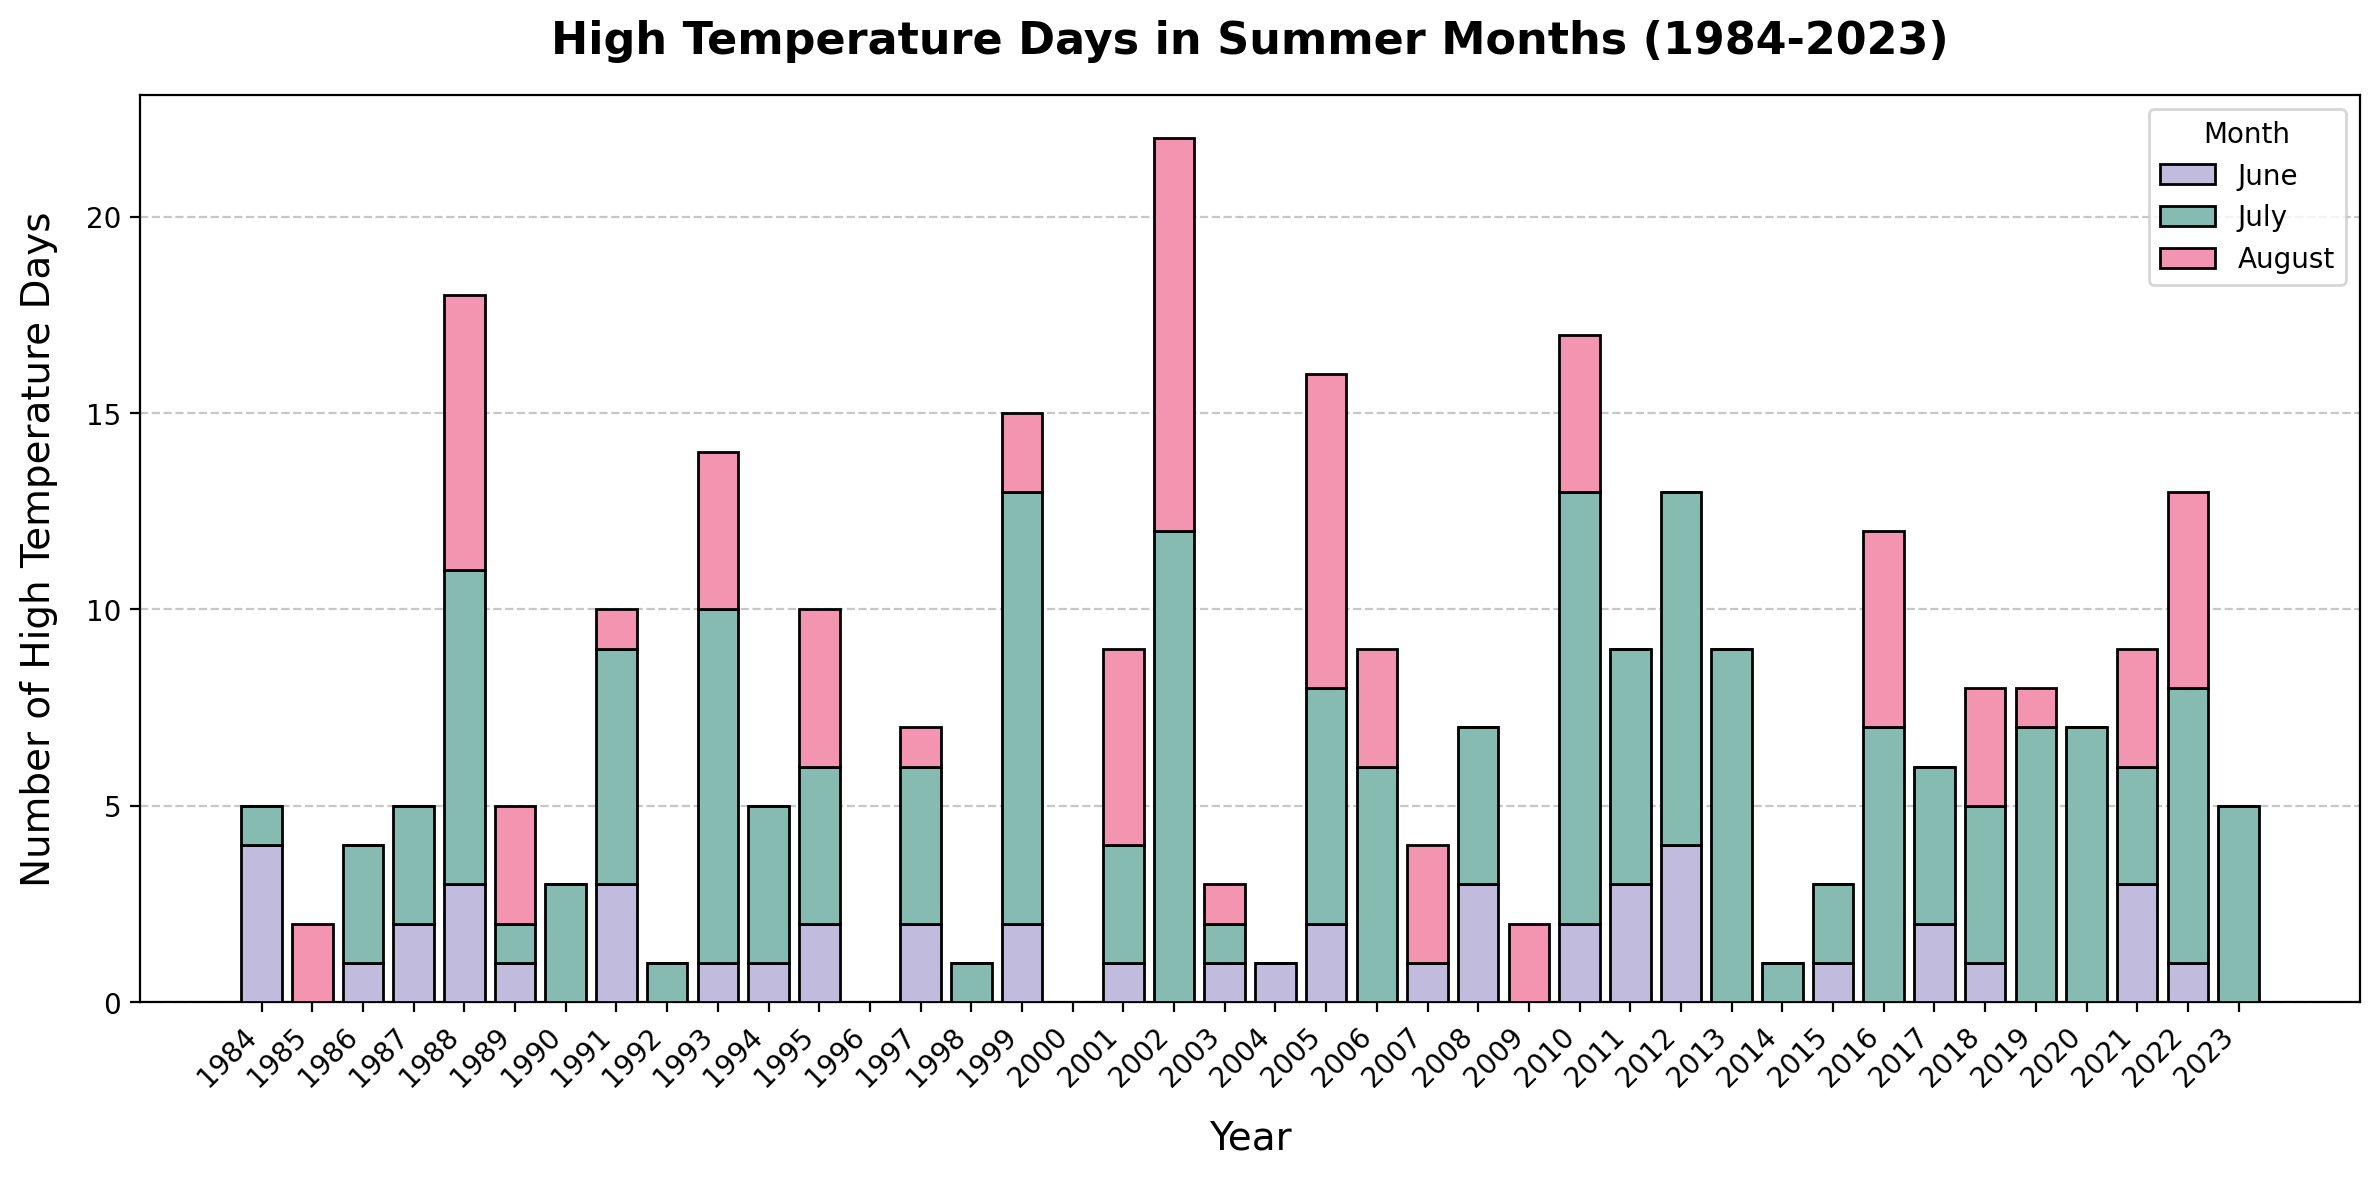

In [47]:
summer_months = [6, 7, 8]
summer_high_temp_days = high_temp_days.sel(time=high_temp_days['time.month'].isin(summer_months))

# Group by year and month, then sum
monthly_summer_high_temp_days = summer_high_temp_days.groupby("time.year").sum()

# Prepare data for plotting
years = monthly_summer_high_temp_days['year'].values
june_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 6).groupby("time.year").sum()
july_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 7).groupby("time.year").sum()
august_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 8).groupby("time.year").sum()

# Create the plot
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(years))
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder = 0)
plt.bar(index, june_days, label='June', edgecolor="black", color=(193/255, 187/255, 221/255), zorder = 3)
plt.bar(index, july_days, bottom=june_days, label='July',edgecolor="black", color=(134/255, 187/255, 177/255), zorder = 3)
plt.bar(index, august_days, bottom=june_days+july_days,label='August', edgecolor="black",color=(243/255, 149/255, 176/255), zorder = 3)

plt.title('High Temperature Days in Summer Months (1984-2023)', fontsize=16, fontweight="bold", pad=15)
plt.xlabel('Year',  fontsize=14, labelpad=10)
plt.ylabel('Number of High Temperature Days',  fontsize=14, labelpad=10)
plt.xticks(index, years, rotation=45, ha='right')
plt.legend(title='Month')

plt.tight_layout()

## 2.2 High Temperature Days Distribution in Summer Months

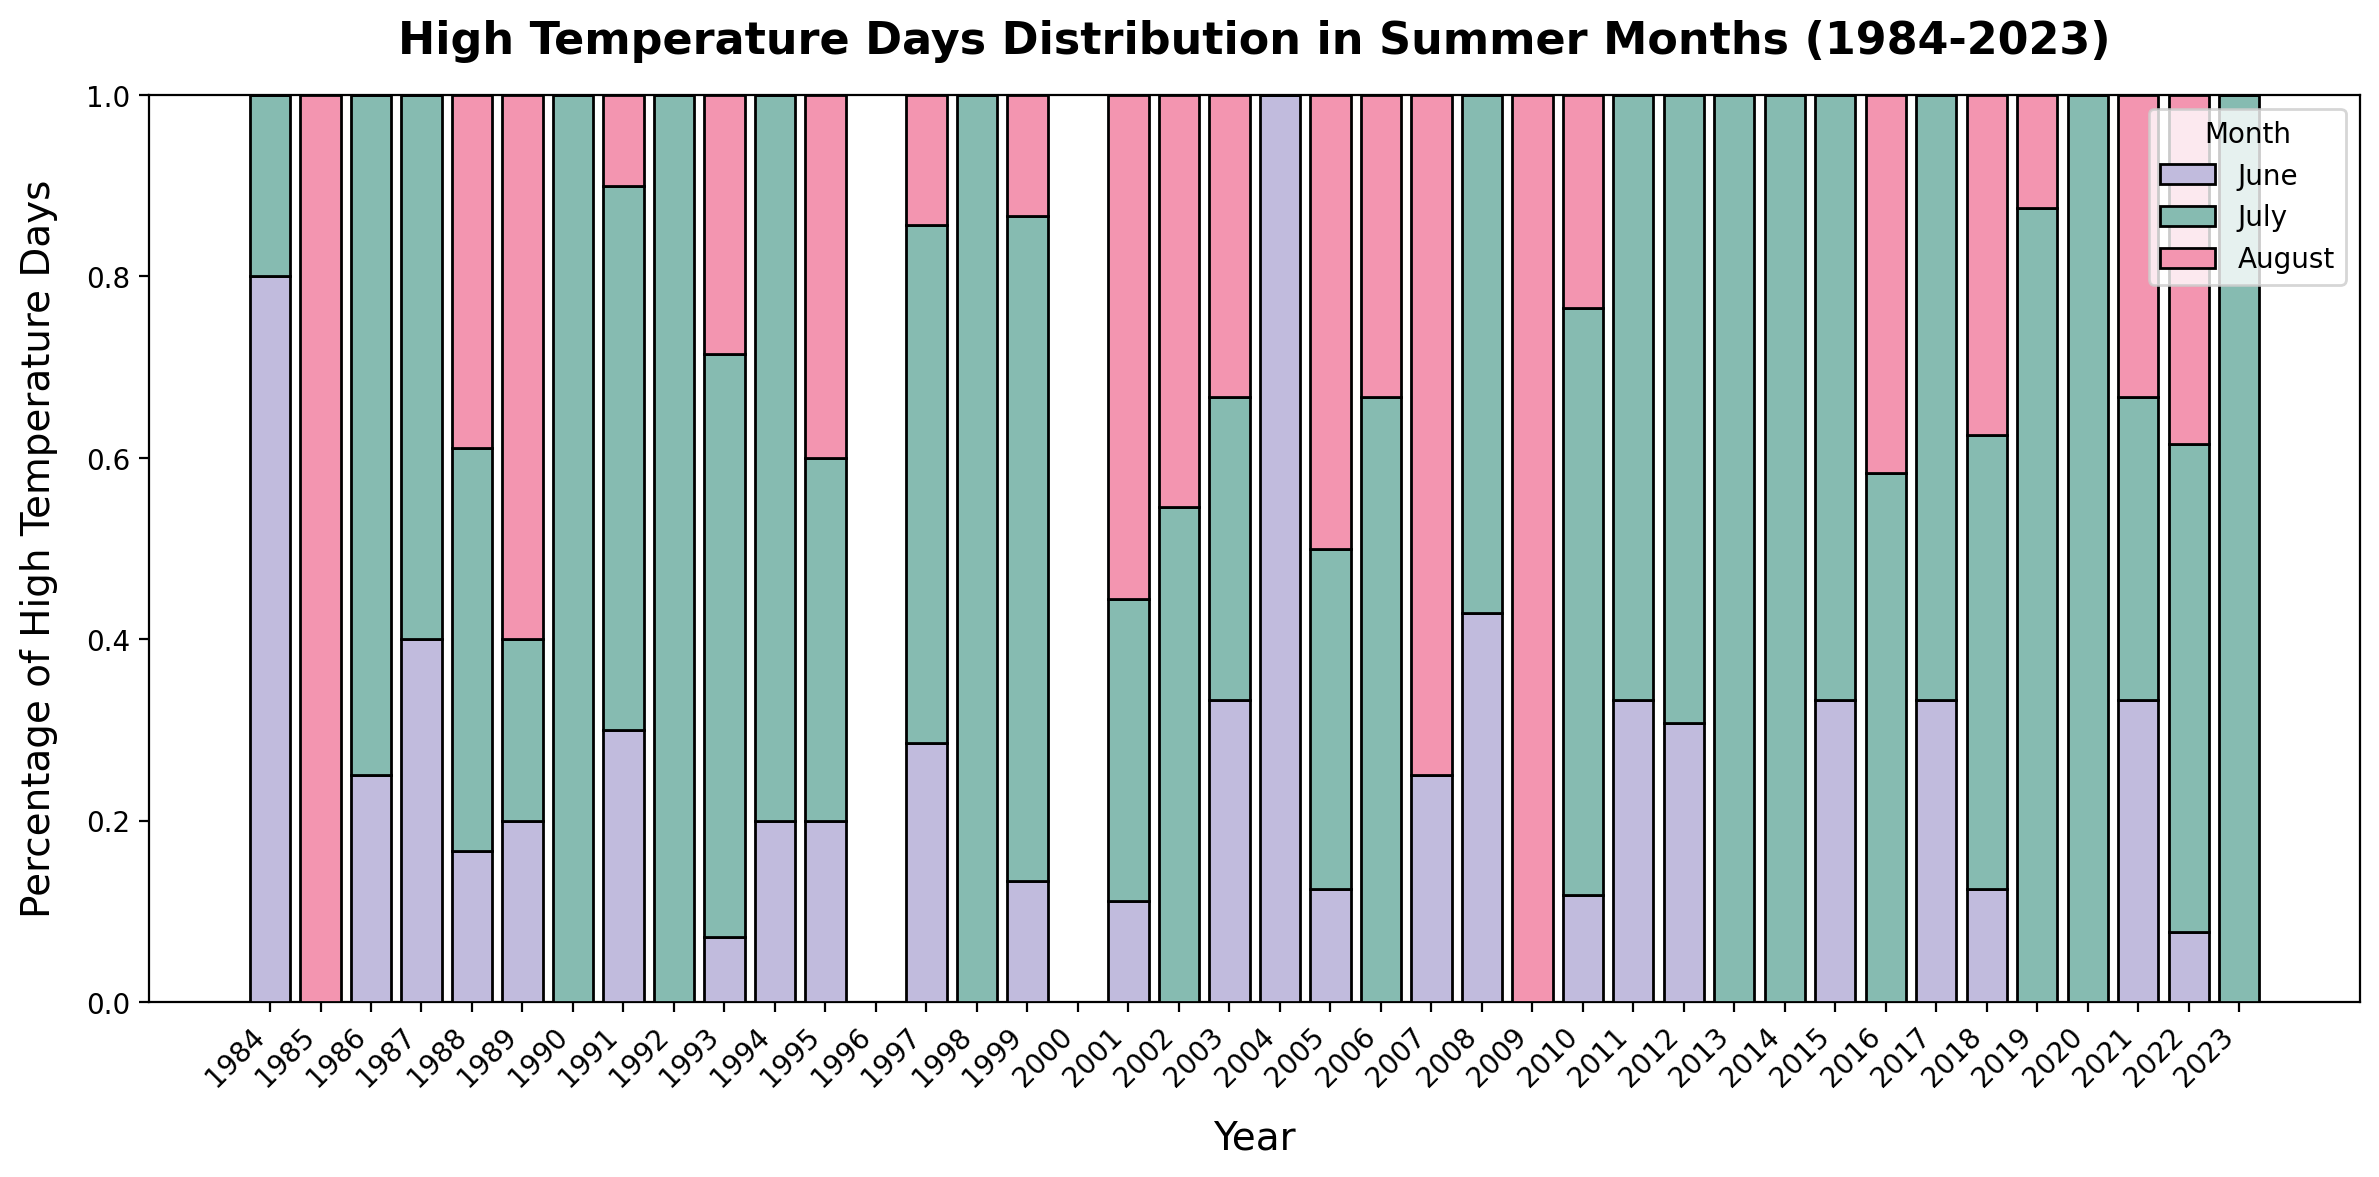

In [46]:
summer_high_temp_days = high_temp_days.sel(time=high_temp_days['time.month'].isin(summer_months))

# Group by year and month, then sum
monthly_summer_high_temp_days = summer_high_temp_days.groupby("time.year").sum()

# Prepare data for plotting
years = monthly_summer_high_temp_days['year'].values
june_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 6).groupby("time.year").sum()
july_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 7).groupby("time.year").sum()
august_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 8).groupby("time.year").sum()

june_percent = june_days/monthly_summer_high_temp_days
july_percent = july_days/monthly_summer_high_temp_days
august_percent = august_days/monthly_summer_high_temp_days

plt.bar(index, june_percent, label='June', edgecolor="black", color=(193/255, 187/255, 221/255), zorder = 3)
plt.bar(index, july_percent, bottom=june_percent, label='July',edgecolor="black", color=(134/255, 187/255, 177/255), zorder = 3)
plt.bar(index, august_percent, bottom=june_percent+july_percent,label='August', edgecolor="black",color=(243/255, 149/255, 176/255), zorder = 3)


plt.title('High Temperature Days Distribution in Summer Months (1984-2023)', fontsize=16, fontweight="bold", pad=15)
plt.xlabel('Year',  fontsize=14, labelpad=10)
plt.ylabel('Percentage of High Temperature Days',  fontsize=14, labelpad=10)
plt.xticks(index, years, rotation=45, ha='right')
plt.legend(title='Month')

plt.tight_layout()

# 3. Historical Temperature Extremes

## 3.1 Comparison of Historical Highest and Lowest Temperatures

In [24]:
winter_min_temp_path = '/home/jovyan/rces-assignments/Project/final/winter_temp.nc'
winter_min_temp = xr.open_dataset(winter_min_temp_path) - 273.15
print(f"\n winter_min_temp:\n{winter_min_temp}")


 winter_min_temp:
<xarray.Dataset> Size: 176kB
Dimensions:    (time: 14670)
Coordinates:
    number     int64 8B ...
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
    latitude   float64 8B ...
    longitude  float64 8B ...
  * time       (time) datetime64[ns] 117kB 1984-01-01 1984-01-02 ... 2024-02-29
Data variables:
    t2m        (time) float32 59kB -6.232 -2.908 -1.799 ... 2.256 10.66 0.0242
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-30T04:02 GRIB to CDM+CF via cfgrib-0.9.1...


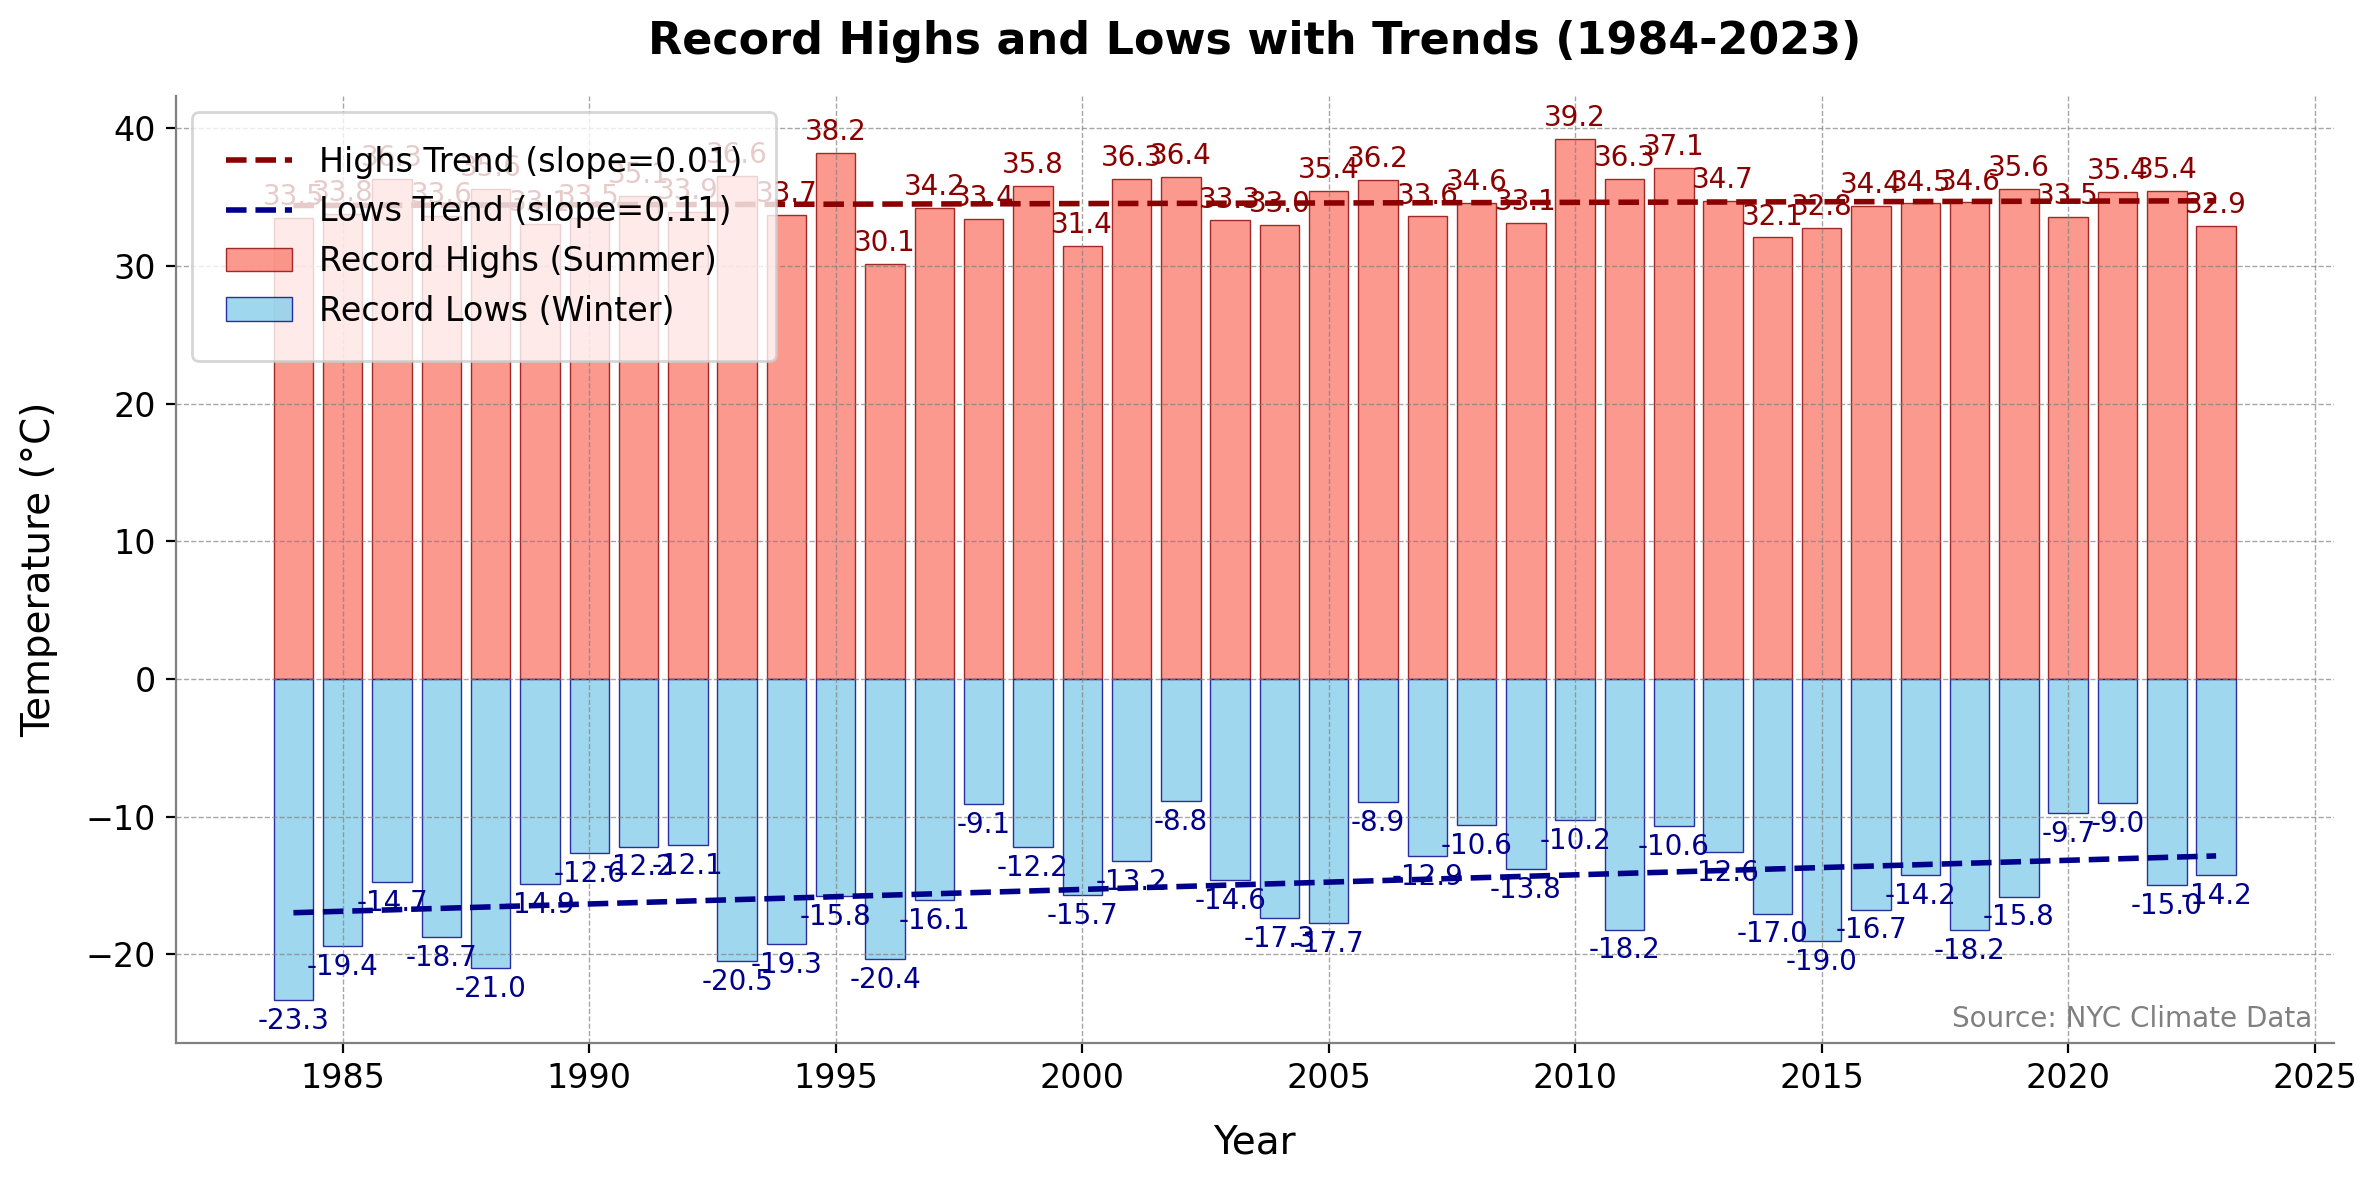

In [29]:
summer_temps = daily_max_temp['t2m']  
winter_temps = winter_min_temp['t2m']  

summer_max_by_year = summer_temps.groupby(summer_temps['time.year']).max(dim='time')

winter_min_by_year = winter_temps.groupby(winter_temps['time.year']).min(dim='time')

summer_years = summer_max_by_year['year'].values
winter_years = winter_min_by_year['year'].values

common_years = set(summer_years).intersection(set(winter_years))

summer_filtered = summer_max_by_year.sel(year=list(common_years))
winter_filtered = winter_min_by_year.sel(year=list(common_years))

record_data = pd.DataFrame({
    "Year": summer_filtered['year'].values,
    "Record Highs (Summer)": summer_filtered.values,
    "Record Lows (Winter)": winter_filtered.values
})

years = record_data["Year"]
record_highs = record_data["Record Highs (Summer)"]
record_lows = record_data["Record Lows (Winter)"]

slope_high, intercept_high, _, _, _ = linregress(years, record_highs)
trend_high = slope_high * years + intercept_high

slope_low, intercept_low, _, _, _ = linregress(years, record_lows)
trend_low = slope_low * years + intercept_low

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(years, record_highs, color="salmon", label="Record Highs (Summer)", alpha=0.8, edgecolor="darkred", linewidth=0.5)
ax.bar(years, record_lows, color="skyblue", label="Record Lows (Winter)", alpha=0.8, edgecolor="darkblue", linewidth=0.5)

ax.plot(years, trend_high, color="darkred", linestyle="--", linewidth=2, label=f"Highs Trend (slope={slope_high:.2f})")
ax.plot(years, trend_low, color="darkblue", linestyle="--", linewidth=2, label=f"Lows Trend (slope={slope_low:.2f})")

ax.grid(visible=True, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("gray")
ax.spines["bottom"].set_color("gray")

# Title and labels
ax.set_title("Record Highs and Lows with Trends (1984-2023)", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Year", fontsize=14, labelpad=10)
ax.set_ylabel("Temperature (°C)", fontsize=14, labelpad=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(12)

for i, (high, low) in enumerate(zip(record_highs, record_lows)):
    ax.text(years[i], high + 0.5, f"{high:.1f}", ha="center", va="bottom", fontsize=10, color="darkred")
    ax.text(years[i], low - 0.5, f"{low:.1f}", ha="center", va="top", fontsize=10, color="darkblue")

# Annotation
ax.annotate("Source: NYC Climate Data", xy=(0.99, 0.01), xycoords="axes fraction",
            fontsize=10, color="gray", ha="right", va="bottom")

# Legend
ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=True, framealpha=0.8, borderpad=1)

plt.tight_layout()
plt.show()

## 3.2 Representative Years High Temprature Characristic Analysis

In [14]:
#high temp consecutive
def calculate_consecutive_high_temps(daily_max_temp, threshold=32):
    years_to_calculate = [1988, 2002, 2010, 2022]
    yearly_results = {}

    for year in years_to_calculate:
        yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
        
        high_temp_flags = (yearly_data >= threshold).astype(int)
        
        diff = high_temp_flags.diff(dim='time', label='lower').fillna(0)  # 填补第一天的 NaN
        consecutive_days = (diff != 0).cumsum(dim='time')
        
        consecutive_days = consecutive_days.pad({'time': (1, 0)}, constant_values=0)
        
        consecutive_days = consecutive_days.assign_coords(time=high_temp_flags['time'])
        
        group_counts = high_temp_flags.groupby(consecutive_days).sum(dim='time')
        
        total_consecutive_high_temps = group_counts.where(group_counts > 1).sum().item()

        yearly_results[year] = total_consecutive_high_temps
        
        
        print(f"Year: {year}, Consecutive High-Temp Days: {total_consecutive_high_temps}")

    return yearly_results

result = calculate_consecutive_high_temps(daily_max_temp)
print(f"\nFinal Result:\n{result}")

Year: 1988, Consecutive High-Temp Days: 16.0
Year: 2002, Consecutive High-Temp Days: 18.0
Year: 2010, Consecutive High-Temp Days: 10.0
Year: 2022, Consecutive High-Temp Days: 11.0

Final Result:
{1988: 16.0, 2002: 18.0, 2010: 10.0, 2022: 11.0}


In [15]:
#extreme temp consecutive
def calculate_consecutive_high_temps(daily_max_temp, threshold=35):
  
    years_to_calculate = [1988, 2002, 2010, 2022]
    yearly_results = {}

    for year in years_to_calculate:
        yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
        
        high_temp_flags = (yearly_data >= threshold).astype(int)
        
        diff = high_temp_flags.diff(dim='time', label='lower').fillna(0)  # 填补第一天的 NaN
        consecutive_days = (diff != 0).cumsum(dim='time')
        
        consecutive_days = consecutive_days.pad({'time': (1, 0)}, constant_values=0)
        
        consecutive_days = consecutive_days.assign_coords(time=high_temp_flags['time'])
        
        
        group_counts = high_temp_flags.groupby(consecutive_days).sum(dim='time')
        
        total_consecutive_high_temps = group_counts.where(group_counts > 1).sum().item()
        
        yearly_results[year] = total_consecutive_high_temps
        
        print(f"Year: {year}, Consecutive High-Temp Days: {total_consecutive_high_temps}")

    
    return yearly_results

result = calculate_consecutive_high_temps(daily_max_temp)
print(f"\nFinal Result:\n{result}")

Year: 1988, Consecutive High-Temp Days: 0.0
Year: 2002, Consecutive High-Temp Days: 2.0
Year: 2010, Consecutive High-Temp Days: 3.0
Year: 2022, Consecutive High-Temp Days: 0.0

Final Result:
{1988: 0.0, 2002: 2.0, 2010: 3.0, 2022: 0.0}


In [18]:
#extreme temp days

thresholds_extreme = 35
extreme_temp_days = (daily_max_temp['t2m'] >= thresholds_extreme).astype(int)
extreme_temp_days_per_year = extreme_temp_days.groupby("time.year").sum()

years = extreme_temp_days_per_year["year"].values 
extreme_temp_days_counts = extreme_temp_days_per_year.values 
selected_years = [1988, 2002, 2010, 2022]
selected_counts = {
    year: extreme_temp_days_per_year.sel(year=year).item()
    for year in selected_years
}

for year, count in selected_counts.items():
    print(f"Year: {year}, Extreme Heat Days: {count}")

Year: 1988, Extreme Heat Days: 2
Year: 2002, Extreme Heat Days: 2
Year: 2010, Extreme Heat Days: 3
Year: 2022, Extreme Heat Days: 1


In [19]:
#extreme temp

max_values_per_year = {}

for year in selected_years:
    yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
    max_temp = yearly_data.max().values
    max_values_per_year[year] = max_temp

for year, max_temp in max_values_per_year.items():
    print(f"Year: {year}, Max Daily Temperature: {max_temp:.2f}°C")

Year: 1988, Max Daily Temperature: 35.61°C
Year: 2002, Max Daily Temperature: 36.44°C
Year: 2010, Max Daily Temperature: 39.24°C
Year: 2022, Max Daily Temperature: 35.43°C


In [20]:
#high temp days
thresholds_per_year = 32
high_temp_days = (daily_max_temp['t2m'] >= thresholds_per_year).astype(int)
high_temp_days_per_year = high_temp_days.groupby("time.year").sum()

years = extreme_temp_days_per_year["year"].values 
high_temp_days_counts = high_temp_days_per_year.values 
selected_years = [1988, 2002, 2010, 2022]
selected_counts = {
    year: high_temp_days_per_year.sel(year=year).item()
    for year in selected_years
}

for year, count in selected_counts.items():
    print(f"Year: {year}, high Heat Days: {count}")

Year: 1988, high Heat Days: 18
Year: 2002, high Heat Days: 22
Year: 2010, high Heat Days: 17
Year: 2022, high Heat Days: 13


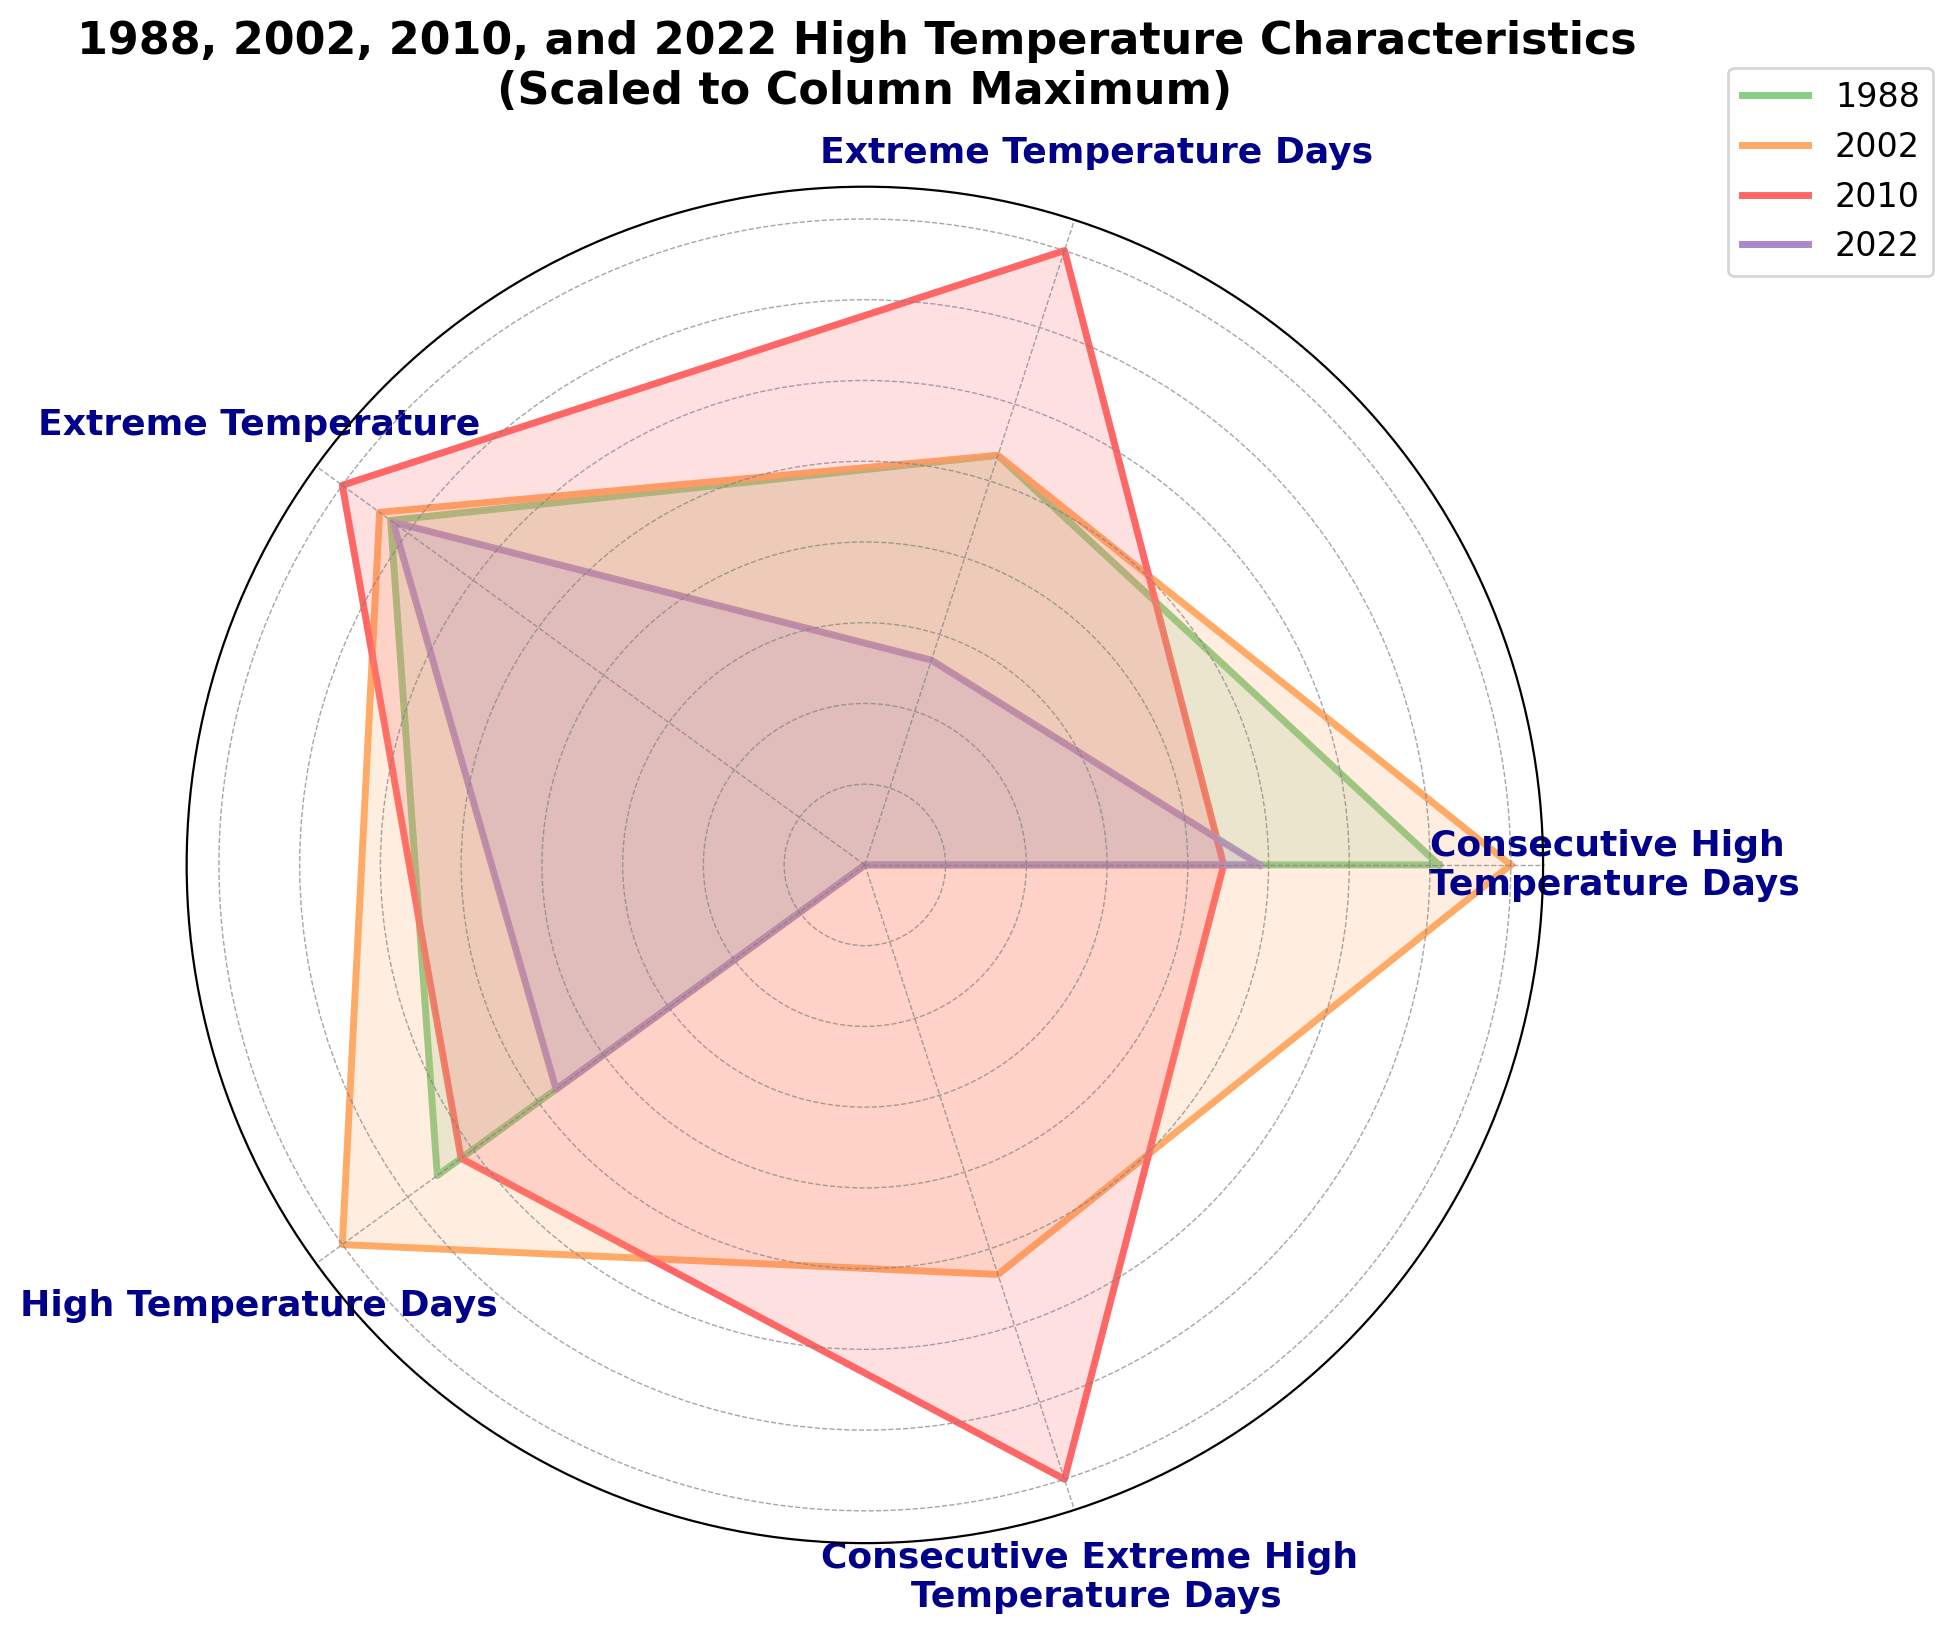

In [43]:
labels = ['Consecutive High \nTemperature Days', 'Extreme Temperature Days', 'Extreme Temperature', 
          'High Temperature Days', 'Consecutive Extreme High \nTemperature Days']
data_1988 = [16.0, 2, 35.61, 18, 0.0]
data_2002 = [18.0, 2, 36.44, 22, 2.0]
data_2010 = [10.0, 3, 39.24, 17, 3.0]
data_2022 = [11.0, 1, 35.43, 13, 0.0]

data_matrix = np.array([data_1988, data_2002, data_2010, data_2022])

max_values = np.max(data_matrix, axis=0)
scaled_data_1988 = (np.array(data_1988) / max_values) * 40
scaled_data_2002 = (np.array(data_2002) / max_values) * 40
scaled_data_2010 = (np.array(data_2010) / max_values) * 40
scaled_data_2022 = (np.array(data_2022) / max_values) * 40

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
scaled_data_1988 = np.concatenate((scaled_data_1988, [scaled_data_1988[0]]))
scaled_data_2002 = np.concatenate((scaled_data_2002, [scaled_data_2002[0]]))
scaled_data_2010 = np.concatenate((scaled_data_2010, [scaled_data_2010[0]]))
scaled_data_2022 = np.concatenate((scaled_data_2022, [scaled_data_2022[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw=dict(polar=True))

ax.plot(angles, scaled_data_1988, color='#88CC88', linewidth=2.5, label='1988',zorder = 0)
ax.plot(angles, scaled_data_2002, color='#FFAA66', linewidth=2.5, label='2002',zorder = 0)
ax.plot(angles, scaled_data_2010, color='#FF6666', linewidth=2.5, label='2010',zorder = 0)
ax.plot(angles, scaled_data_2022, color='#AA88CC', linewidth=2.5, label='2022',zorder = 0)

ax.fill(angles, scaled_data_1988, color='#88CC88', alpha=0.2,zorder = 0)
ax.fill(angles, scaled_data_2002, color='#FFAA66', alpha=0.2,zorder = 0)
ax.fill(angles, scaled_data_2010, color='#FF6666', alpha=0.2,zorder = 0)
ax.fill(angles, scaled_data_2022, color='#AA88CC', alpha=0.2,zorder = 0)

ax.set_yticklabels([], zorder = 3)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=13, fontweight='bold', color='darkblue')
ax.tick_params(axis='x', pad=15)

ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

plt.title("1988, 2002, 2010, and 2022 High Temperature Characteristics \n(Scaled to Column Maximum)", 
          fontsize=16, fontweight='bold', pad=30, color='k')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12, frameon=True, fancybox=True, framealpha=0.8)

plt.tight_layout()
plt.show()